## Advanced Component Implementation

# 1 Author

**Student Name**: ARKO CHATTERJEE <br>
**Student ID**:  210804539

---

In [1]:
!pip install librosa
!pip install xgboost

  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached audioread-3.0.0-py3-none-any.whl
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached soundfile-0.11.0-py2.py3-none-any.whl (23 kB)
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached xgboost-1.7.2-py3-none-manylinux2014_x86_64.whl (193.6 MB)

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
#required dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, re, pickle, glob
import urllib.request
import zipfile
import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display
import random

import sklearn
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

---
# 2 Problem formulation

Using the MLEnd London Sounds dataset, I am proposing to build a machine learning model to  <b>predict the area</b> of the input audio sample.<br>
The plan is also to employ the spot and indoor/outdoor datapoints as predictors to view if it assists in improving the model or not!

<br>

---

# 3 Machine Learning pipeline

Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. 



<br>

---

# 4 Transformation stage



In [3]:
sample_path = '/home/jovyan/ML/DATA/DATA_unzip_full/*.wav'
files = glob.glob(sample_path)

This audio signal has 313110 samples


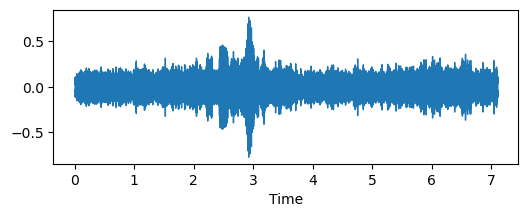

In [4]:
n = 99
fs = None

x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

plt.figure(figsize=(6, 2))
librosa.display.waveshow(x, sr=fs)
plt.show()

display(ipd.Audio(files[n]))

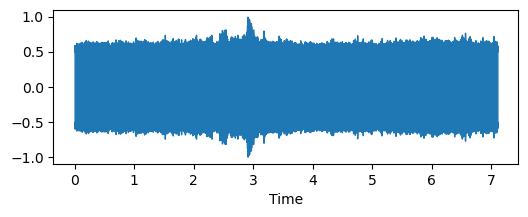

In [5]:
'''

1. Normalization of input audio sample

-> ideally done to adjust volume of audio to a fixed level
-> otherwise - some specfic words said with different volume would not be a good feature to train a model

'''

x = sklearn.preprocessing.minmax_scale(x, axis=0)

plt.figure(figsize=(6, 2))
librosa.display.waveshow(x, sr=fs)
plt.show()

In [6]:
'''

2. Pre-Emphasis of input audio sample

-> pre-emphasis is a noise reduction technique
-> ideally done to compensate high frequency portion of a sample

'''

y = librosa.effects.preemphasis(x)

shape of mfcc coef ->  (20, 612)


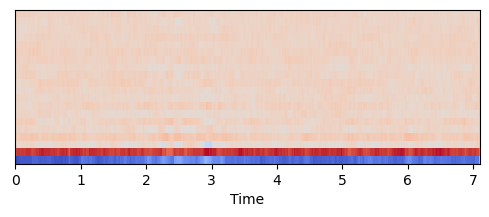

In [7]:
'''

3. Mel-Frequency Cepstral Coefficients (MFCC) - done after Normalization and Pre-Emphasis

-> it is a type of spectral feature 
-> in prinicple for MFCC, it divides the audio sample into small intervals/windows and 
calcucates intricate MFCC features (20 each or 40) for each interval

'''

mfccs = librosa.feature.mfcc(y = x, sr=fs)
print('shape of mfcc coef -> ', mfccs.shape)

plt.figure(figsize=(6, 2))
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

mfccs_processed = np.mean(mfccs.T,axis=0)

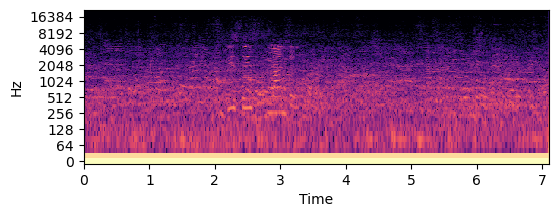

In [8]:
'''

4. Short Term Fourier Transform (STFT) - done after Normalization and Pre-Emphasis

-> it is a windowed Fourier Transform and uses a single window size to compute the FT
-> in prinicple STFT helps to analyze how the frequency content of a nonstationary signal changes over time

'''

stft = librosa.stft(x)

plt.figure(figsize=(6, 2))
db = librosa.amplitude_to_db(stft,ref=np.max)
librosa.display.specshow(db, sr=fs, y_axis='log', x_axis='time')
plt.show()

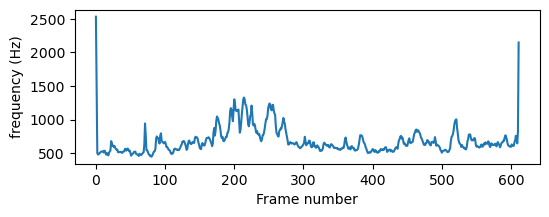

In [9]:
'''

5. Spectral Centroid - done after Normalization and Pre-Emphasis

-> it determines the characteristic of a spectrum
-> is indicative of centre of mass of spectrum

'''

spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=fs)[0]

plt.figure(figsize=(6, 2))
plt.xlabel('Frame number')
plt.ylabel('frequency (Hz)')
plt.plot(spectral_centroids)
plt.show()

In [10]:
'''

6. Spectral Bandwidth - done after Normalization and Pre-Emphasis

-> sum of maximum deviation of the signal on both sides of the point (timeframe) is the spectral bandwidth

'''

spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)

In [11]:
'''

7. Spectral Rolloff - done after Normalization and Pre-Emphasis

-> ideally designed to roll off frequencies outside to a specific range
-> spectral roll-off point is the fraction of bins in the power spectrum at which 85% of the power is at lower frequencies

'''

rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)

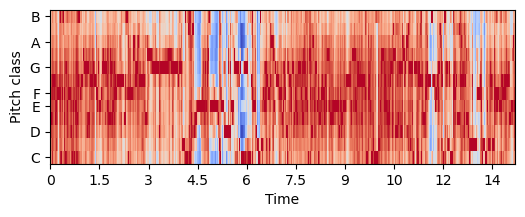

In [12]:
'''

8. Chroma Frequencies - done after Normalization and Pre-Emphasis

-> is indicative of high degree of robustness to variations in timbre
-> is indicative to closely correlate to the musical aspect of harmony
-> in principle the entire spectrum is segregated into 12 bins denoting 12 distinct semitones

(ref : https://www.ee.columbia.edu/~dpwe/resources/matlab/chroma-ansyn/ )

'''

chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)

plt.figure(figsize=(6, 2))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.show()

In [5]:
'''

9. Power & Root Mean Square Energy - done after Normalization and Pre-Emphasis

-> is indicative of total mangitude of audio sample (how loud the audio is)
-> is indicative to closely correlate to the musical aspect of harmony
-> in principle the entire spectrum is segregated into 12 bins denoting 12 distinct semitones

(ref : https://www.ee.columbia.edu/~dpwe/resources/matlab/chroma-ansyn/ )

'''

power = np.sum(x**2)/len(x)


rmse = librosa.feature.rms(x)

In [14]:
'''

10. Zero Crossing Rate - done after Normalization and Pre-Emphasis

-> it is a weighted count of number of times signal change sign in frame
-> is indicative of smoothness of a sound
-> ZCR is high for noisy sample and low for tonal sample

'''

zcr = librosa.feature.zero_crossing_rate(x)

In [15]:
'''

11. Fundamental frequency (F0) estimation using probabilistic YIN (pYIN) - done after Normalization and Pre-Emphasis

-> Pitch - done after computing F0 using pYIN
-> a property of sound corresponding to the frequency of the audio sample
-> indicative of relative (high/low)ness of audio sample


ref : https://www.eecs.qmul.ac.uk/~simond/pub/2014/MauchDixon-PYIN-ICASSP2014.pdf

'''

def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

f0, voiced_flag = getPitch(x,fs,winLen=0.02)

pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
voiced_fr = np.mean(voiced_flag)

### Initial pre-processing of all audio samples using features listed above

In [81]:
MLENDLS_df = pd.read_csv('/home/jovyan/ML/git-code/MLEndLS_final.csv').set_index('file_id') 
MLENDLS_df

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176
...,...,...,...,...
2496.wav,westend,trafalgar,outdoor,S151
2497.wav,campus,square,outdoor,S6
2498.wav,westend,national,indoor,S96


In [16]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [17]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    
    try:
        
        fs = None # if None, fs would be 22050 #fr = sr = sampling rate
        x, fs = librosa.load(file,sr=fs)
    
        if scale_audio: 
            #x = x/np.max(np.abs(x))
            x = sklearn.preprocessing.minmax_scale(x, axis=axis)
            x = librosa.effects.preemphasis(x)
            
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
        
        y1 = labels_file.loc[fileID]['in_out']
        y2 = labels_file.loc[fileID]['area']
        y3 = labels_file.loc[fileID]['spot']
        y4 = labels_file.loc[fileID]['Participant']
        y5 = fileID
        yi = [ y1, y2, y3, y4, y5 ]
        
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        
        mfccs = librosa.feature.mfcc(y = x, sr=fs)
        spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=fs)[0]
        
        rmse = librosa.feature.rms(y=x)
        chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)
        spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
        rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
        zcr = librosa.feature.zero_crossing_rate(x)

        xi = [power,pitch_mean,pitch_std,voiced_fr, np.mean(np.mean(mfccs.T,axis=0)), np.mean(spectral_centroids), np.mean(rmse), np.mean(chroma_stft), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
        
        X.append(xi)
        y.append(yi)
        
    except:
        print('issue in file index -->' + str(file))
      
    

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(sample_file, labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

### have saved all data for 2500 audio samples to a feature CSV file! 
[ took 2.5 hours :) ]

---

# 5 Modelling

There are 4 approaches using 4 different algorithms/models : <br><br>
<b>1. SVC </b><br>
- can effectively handle high dimensional data
- well suited for linear and non-linear data (sound features in this case) as it uses kernel function to create a hyperplane


<b>2. Logistic Regression</b><br>
- simple and interpretable model than can be easily trained in a much faster timeframe

<b>3. XGBoost (Extreme Gradient Boosting)</b><br>
- it is an ensemble model - combines the predictions of multiple weak models to produce a more accurate and robust prediction!

<b>4. Simple Neural Network</b>
- neural nets can learn complex, nonlinear relationships in the audio samples and a couple of optimizations can be added to see how it works.


# 6 Methodology

for all of the algorithms mentioned above the methodology remains the same 
- split dataset into train and validation
- pass them through the model to train and thereafter predict
- analyze the confusion matrix of the model

---

# 7 Dataset

- We have pre computed 11 features of all 2500 audio samples and saved the featues as CSV for further use!
- also appened all data (spot, area, indoor/outdoor, participantID) into single file for feasibility
- audio feature from left to right are as follows - [ power ,pitch_mean, pitch_std, voiced_fr, mfcc, spectral_centroid, rmse, chroma_stft, spectral_bandwidth, rolloff, zero crossing rate ] 

In [2]:
df_adv = pd.read_csv('/home/jovyan/ML/git-code/feature-set-4-adv-full.csv').set_index('id') 
df_adv

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,0_y,1_y,2_y,3_y,4_y
id,,,,,,,,,,,,,,,,
0,0.000306,0.000000,0.000000,0.000000,-9.704526,3924.455408,0.017407,0.662082,3863.928224,7658.032325,0.044540,outdoor,british,street,S81,1091.wav
1,0.000239,168.840522,27.394508,0.054902,-12.685133,3354.621682,0.014910,0.810797,4373.337647,8323.694853,0.009006,outdoor,campus,square,S183,2114.wav
2,0.000415,0.000000,0.000000,0.000000,-11.732181,3855.839005,0.020163,0.571700,3295.748205,7031.123140,0.087092,indoor,westend,market,S64,1313.wav
3,0.000469,0.000000,0.000000,0.000000,-8.620403,5825.834241,0.021463,0.694621,4406.635488,11211.221849,0.112260,outdoor,british,street,S151,0001.wav
4,0.000279,237.049695,55.445517,0.113145,-15.675273,2271.428776,0.016332,0.455131,2419.640870,4578.833211,0.024275,indoor,westend,charing,S94,1614.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.000318,127.043657,11.591387,0.095469,-14.222832,2130.724309,0.017640,0.639185,2652.933177,4891.556290,0.014187,indoor,westend,national,S97,0804.wav
2496,0.000459,89.758892,4.978481,0.004886,-16.421215,4148.489347,0.020931,0.541413,3423.110084,7694.718292,0.108947,indoor,campus,ground,S106,1143.wav
2497,0.000226,106.654105,2.121523,0.027548,-9.625125,6846.068155,0.014362,0.698250,5644.173536,14005.658009,0.080098,outdoor,Euston,forecourt,S47,1733.wav


In [3]:
'''

listing total number of data across 6 labels

we can see here, that the classes are highly imbalanced! 

this can be improved by the following techniques : 
- data augmentation to upsample the lower count classess OR downsample the higher count classes

'''

df_adv['1_y'].value_counts()

campus        823
westend       666
british       404
Euston        234
southbank     229
kensington    144
Name: 1_y, dtype: int64

In [4]:
'''

for simplicity purposes - we are rejigging our problem statement to predict between 2 areas - 'westend' & 'british'

because these two labels have comparable sample sizes! 

'''

options = ['british', 'westend']
df_1 = df_adv.loc[df_adv['1_y'].isin(options)]
df_1

,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,0_y,1_y,2_y,3_y,4_y
id,,,,,,,,,,,,,,,,
0,0.000306,0.000000,0.000000,0.000000,-9.704526,3924.455408,0.017407,0.662082,3863.928224,7658.032325,0.044540,outdoor,british,street,S81,1091.wav
2,0.000415,0.000000,0.000000,0.000000,-11.732181,3855.839005,0.020163,0.571700,3295.748205,7031.123140,0.087092,indoor,westend,market,S64,1313.wav
3,0.000469,0.000000,0.000000,0.000000,-8.620403,5825.834241,0.021463,0.694621,4406.635488,11211.221849,0.112260,outdoor,british,street,S151,0001.wav
4,0.000279,237.049695,55.445517,0.113145,-15.675273,2271.428776,0.016332,0.455131,2419.640870,4578.833211,0.024275,indoor,westend,charing,S94,1614.wav
5,0.000324,0.000000,0.000000,0.000000,-10.472139,4983.050552,0.017779,0.615757,5168.297849,10719.246636,0.032935,outdoor,british,street,S51,0223.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.000241,434.355841,2.031758,0.059375,-15.680769,4860.805350,0.015170,0.692632,4698.817554,10670.375061,0.025005,indoor,british,room12,S100,1280.wav
2488,0.000260,125.535538,9.984343,0.022962,-17.815416,4675.329058,0.014585,0.827844,4535.200992,10154.129032,0.011396,outdoor,british,forecourt,S134,1342.wav
2492,0.000279,0.000000,0.000000,0.000000,-13.503522,3738.124404,0.016404,0.693977,3497.334053,7691.357281,0.011143,indoor,british,room12,S3,0386.wav


In [5]:
'''

- Keeping X as feature sets of the audio sample and indoor/outdoor but removing spot, location and participantID
- Keeping Y as the labels of indoor/outdoor for that particular audio sample

note : not using spots - as there is lot of imbalance in the data!

'''


X = df_1.drop(['1_y', '2_y', '3_y', '4_y'], axis=1)
y = df_1['1_y']


print(df_1['2_y'].value_counts())

piazza        116
charing       113
market        112
national      110
trafalgar     109
leicester     106
greatcourt     84
room12         83
forecourt      82
street         77
square         77
room13          1
Name: 2_y, dtype: int64


In [6]:
'''

Now, we need to encode the indoor/outdoor label list - so that it is easier for the model to predict!

'''


from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(X['0_y'])
print(list(le.classes_))
X['0_y'] = le.transform(X['0_y'])

X

['indoor', 'outdoor']


,0_x,1_x,2_x,3_x,4_x,5,6,7,8,9,10,0_y
id,,,,,,,,,,,,
0,0.000306,0.000000,0.000000,0.000000,-9.704526,3924.455408,0.017407,0.662082,3863.928224,7658.032325,0.044540,1
2,0.000415,0.000000,0.000000,0.000000,-11.732181,3855.839005,0.020163,0.571700,3295.748205,7031.123140,0.087092,0
3,0.000469,0.000000,0.000000,0.000000,-8.620403,5825.834241,0.021463,0.694621,4406.635488,11211.221849,0.112260,1
4,0.000279,237.049695,55.445517,0.113145,-15.675273,2271.428776,0.016332,0.455131,2419.640870,4578.833211,0.024275,0
5,0.000324,0.000000,0.000000,0.000000,-10.472139,4983.050552,0.017779,0.615757,5168.297849,10719.246636,0.032935,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2482,0.000241,434.355841,2.031758,0.059375,-15.680769,4860.805350,0.015170,0.692632,4698.817554,10670.375061,0.025005,0
2488,0.000260,125.535538,9.984343,0.022962,-17.815416,4675.329058,0.014585,0.827844,4535.200992,10154.129032,0.011396,1
2492,0.000279,0.000000,0.000000,0.000000,-13.503522,3738.124404,0.016404,0.693977,3497.334053,7691.357281,0.011143,0


In [7]:
'''

Now, we need to encode the area ( 'campus' or 'westend' ) label list - so that it is easier for the model to predict!

'''
y = df_1['1_y']

le.fit(y)
print(list(le.classes_))
y_n = le.transform(y)
y_n

['british', 'westend']


array([0, 1, 0, ..., 0, 1, 1])

In [29]:
import statsmodels.api as sm

'''

ref : https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

'''

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [30]:
'''

Next step - is to further reduce the feature set using correlation and p value
this is done by using regression model by Ordinary Least Square (OLS) method to compute the p values

we are taking into consideration those columns which has correlation of < 0.8 in this case
'''

corr = X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False

In [31]:
selected_columns = X.columns[columns]

In [32]:
SL = 0.05 # choosing a significance value of 0.05
data_modeled, selected_columns = backwardElimination(X.values, y_n, SL, selected_columns.values)

In [33]:
X = pd.DataFrame(data = data_modeled, columns = selected_columns)
X

,0_x,3_x,4_x,7,8
0,0.000306,0.000000,-9.704526,0.662082,3863.928224
1,0.000415,0.000000,-11.732181,0.571700,3295.748205
2,0.000469,0.000000,-8.620403,0.694621,4406.635488
3,0.000279,0.113145,-15.675273,0.455131,2419.640870
4,0.000324,0.000000,-10.472139,0.615757,5168.297849
...,...,...,...,...,...
1065,0.000241,0.059375,-15.680769,0.692632,4698.817554
1066,0.000260,0.022962,-17.815416,0.827844,4535.200992
1067,0.000279,0.000000,-13.503522,0.693977,3497.334053
1068,0.000318,0.095469,-14.222832,0.639185,2652.933177


In [42]:
'''

splitting train and validation predictor and label dataset for fitting to a ML model!

'''

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y_n,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((749, 5), (321, 5), (749,), (321,))

---

# 8 Results

### Model 1 : SVC (Support Vector Classifier)

Training Accuracy 0.8651535380507344
Validation  Accuracy 0.6697819314641744
The support vectors are (676, 5)


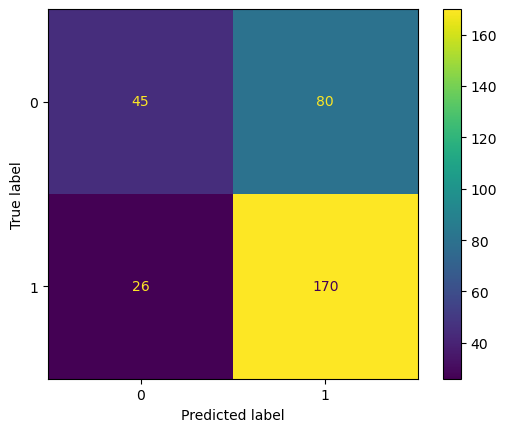

In [44]:
mean = X_train.mean(0)
sd =  X_train.std(0)

'''
z score normalization of predictor X
'''
X_train_n = (X_train-mean)/sd
X_val_n  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train_n,y_train)

yt_p = model.predict(X_train_n)
yv_p = model.predict(X_val_n)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

plot_confusion_matrix(model, X_val_n, y_val)  

'''
Using Z score normalized predictors!

Analysis : 

- labels [ 0 represents british and 1 represents westend ]
- we can infer that model is correctly predicting westend more than british even through the sample is almost balanced!

'''


plt.show()

---

### Model 2 : Logistic Regression

Training Accuracy 0.6568758344459279
Validation  Accuracy 0.6635514018691588


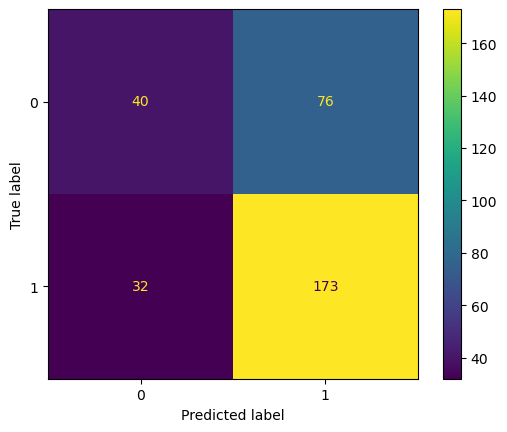

In [37]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train_n,y_train)

yt_p1 = logisticRegr.predict(X_train_n)
yv_p1 = logisticRegr.predict(X_val_n)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

plot_confusion_matrix(logisticRegr, X_val_n, y_val)  

'''
Using Z score normalized predictors!

Analysis : 

- labels [ 0 represents british and 1 represents westend ]
- accuracy took a slight hit, however the issue persists of predicting TP (westend) more

'''


plt.show()

---
### Model 3 : Extreme Gradient Boosting Classifier

Training Accuracy 0.6755674232309746
Validation  Accuracy 0.6635514018691588


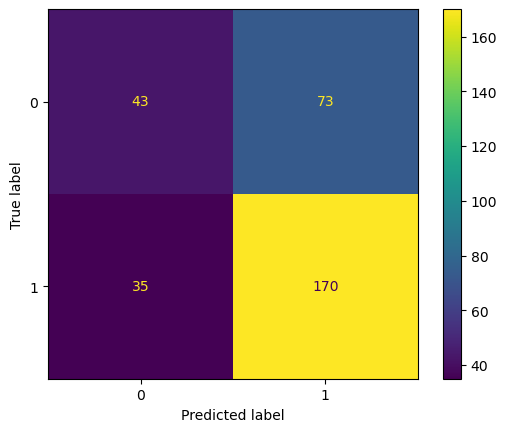

In [40]:
from xgboost import XGBClassifier

params = {
            'max_depth': 2,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':10
        }

modelXGB = XGBClassifier(**params)
modelXGB.fit(X_train_n, y_train)

yt_p1 = modelXGB.predict(X_train_n)
yv_p1 = modelXGB.predict(X_val_n)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

plot_confusion_matrix(modelXGB, X_val_n, y_val)  

'''
Using Z score normalized predictors!

Analysis : 

- labels [ 0 represents british and 1 represents westend ]
- for the same sample size - a interesting point that the training and validation accuracy remains the same

'''


plt.show()

### Model 4 : K Neighbour Classifer

Training Accuracy 0.7636849132176236
Validation  Accuracy 0.6479750778816199


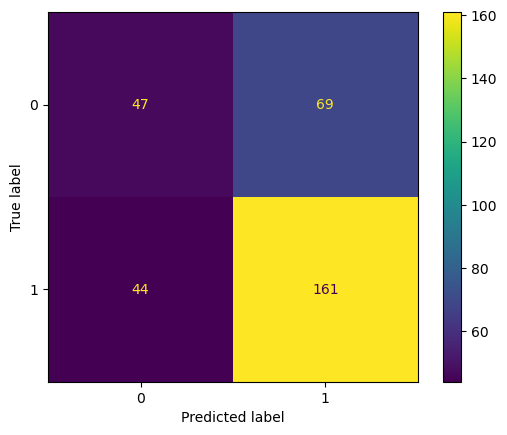

In [38]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_n, y_train)

yt_p1 = neigh.predict(X_train_n)
yv_p1 = neigh.predict(X_val_n)

print('Training Accuracy', np.mean(yt_p1==y_train))
print('Validation  Accuracy', np.mean(yv_p1==y_val))

plot_confusion_matrix(neigh, X_val_n, y_val)  

'''
Using Z score normalized predictors!

Analysis : 

- labels [ 0 represents british and 1 represents westend ]


'''


plt.show()

### Model 5 : Simple Neural Network

In [39]:
from keras import layers
from keras import layers
import keras
from keras.models import Sequential

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train_n.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier = model.fit(X_train_n, y_train, epochs = 50, batch_size = 10)

'''
Using Z score normalized predictors!

simple 4 layer neural network with the following parameters :
- input shape is of size of the predictor
- hidden layer 1 -> 256 nodes with relu activation fn [ ReLu -> if input > 0 it will return input value or zero ]
- hidden layer 2 -> 128 nodes with relu activation fn 
- hidden layer 3 -> 64 nodes with relu activation fn
- output layer -> 10 nodes with softmax activation

Analysis : 

- implemented to test out a simple NN!
- we can see in each epoch accuracy increased to ~80% (testing)

'''

print('Evaluate NN model')
test_loss, test_acc = model.evaluate(X_val_n,y_val)

2022-12-09 15:10:05.985706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 15:10:06.115511: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 15:10:06.146221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-09 15:10:06.610243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Epoch 1/50


2022-12-09 15:10:07.279070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 15:10:09.517511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79120 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:12:00.0, compute capability: 8.0
2022-12-09 15:10:09.518122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79120 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:13:00.0, compute capability: 8.0
2022-12-09 15:10:09.518581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/r

75/75 [==============================] - 2s 1ms/step - loss: 0.9567 - accuracy: 0.6128
Epoch 2/50
36/75 [=============>................] - ETA: 0s - loss: 0.6121 - accuracy: 0.6333

2022-12-09 15:10:12.581115: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


75/75 [==============================] - 0s 1ms/step - loss: 0.6194 - accuracy: 0.6328
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.6071 - accuracy: 0.6582
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.6085 - accuracy: 0.6449
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.6769
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5827 - accuracy: 0.6782
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5888 - accuracy: 0.6702
Epoch 8/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5900 - accuracy: 0.6649
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.6822
Epoch 10/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5781 - accuracy: 0.6876
Epoch 11/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5871 - accuracy: 0.6862
Epoch 12/50
75/75 [==========